# GONZAG WestMed example

This notebook demonstrates how Gonzag can be used to:
- perform a space-time interpolation of SSH on a gridded OGCM domain onto a satellite track (provided in 2 NetCDF input files)
- select and retain N valid SSH along track segments (both for input satellite SSH and interpolated model SSH)
- preprocess these N SSH segments prior to applying a Fast Fourrier Transform (FFT)
- apply the FFT
- plot the the mean spectrum (of the N spectra)
- with zarr inputs

## Loading & initializations

In [1]:
import sys
from os import getenv
import warnings
warnings.filterwarnings("ignore")

GONZAG_DIR   = getenv('HOME')+'/Work/git/gonzag'
sys.path.append(GONZAG_DIR)

import gonzag as gzg
from gonzag.config import ldebug
#make sure IsZarr==True in config.py

GONZAG_DATA_DIR = getenv('HOME')+'/Data/gonzag_input_zarr'

# Satellite input data:
name_sat = 'Sentinel3A'
file_sat = GONZAG_DATA_DIR+'/zarr_SENTINEL3A_20170130-20170303'
name_ssh_sat = 'sla_unfiltered'

# Model input data:
name_mod = 'eNATL60-WestMed'
file_mod = GONZAG_DATA_DIR+'/zarr_sossheig_box_WestMed_eNATL60-BLBT02_20170201-20170228'
name_ssh_mod = 'sossheig'
file_lsm_mod = file_mod; name_lsm_mod = '_FillValue' ; # we use _FillValue attribute of "nams_ssh_mod" in "file_mod"
l_griddist = False ; # grid is not strongly distorded





### Time overlap between model and satellite data ?

In [2]:
    (it1,it2), (Nts,Ntm) = gzg.GetEpochTimeOverlap( file_sat , file_mod )
    print(' *** Time overlap between model and satellite in UNIX epoch time: it1, it2', it1,'--',it2)
    print('   => UTC: "'+gzg.EpochT2Str(it1)+'" to "'+gzg.EpochT2Str(it2)+'"\n')


 *** Time overlap between model and satellite in UNIX epoch time: it1, it2 1485909000.0 -- 1488324600.0
   => UTC: "Wed Feb  1 00:30:00 2017" to "Tue Feb 28 23:30:00 2017"



## Create object `ModelGrid` containing all the model (aka _source_) 2D+T domain grid info

In [3]:
    clsm = name_lsm_mod
    if name_lsm_mod=='_FillValue': clsm = name_lsm_mod+'@'+name_ssh_mod
    
    ModelGrid = gzg.ModGrid( file_mod, it1, it2, file_lsm_mod, clsm, distorded_grid=l_griddist )



 *** what we use to define model land-sea mask:
    => "_FillValue@sossheig" in "/Users/aureliealbert/Data/gonzag_input_zarr/zarr_sossheig_box_WestMed_eNATL60-BLBT02_20170201-20170228"

 *** Skipping computation of angle distortion of the model grid! ("-D" option not invoked)...

 *** About model gridded (source) domain:
     * shape =  (796, 868)
     * horizontal resolution:  0.016753984549605475  degrees or  1.8615352233066644  km
     * Is this a global domain w.r.t longitude:  False
       ==> this is a regional domain
       ==> working in the [-180:180] frame...
     * lon_min, lon_max =  -5.5 9.53
     * lat_min, lat_max =  34.91 45.1
     * should we pay attention to possible STRONG local distorsion in the grid:  False
     * number of time records of interest for the interpolation to come:  672
       ==> time record indices: 0 to 671, included



## Create object `SatelliteTrack` containing all the satellite track (aka _target_) info

In [4]:
SatelliteTrack = gzg.SatTrack( file_sat, it1, it2, Np=Nts, \
                              domain_bounds=ModelGrid.domain_bounds, l_0_360=ModelGrid.l360 )

 *** [SatTrack()] Analyzing the time vector in /Users/aureliealbert/Data/gonzag_input_zarr/zarr_SENTINEL3A_20170130-20170303 ...

 *** About satellite track (target) domain:
     * number of time records of interest for the interpolation to come:  2452
       ==> time record indices: 95570 to 1410931, included



## Build the bilinear mapping & Perform the space-time interpolation

In [5]:
Solution = gzg.Model2SatTrack( ModelGrid, name_ssh_mod, SatelliteTrack, name_ssh_sat )

 *** "found" distance criterion when searching for nearest point on model grid is  1.3961514174799983  km

 *** Will use zoom boxes of width of 269 points for 1st attempts of nearest-point location...


 *** Finding nearest points on source (model) grid... (rd_found_km, np_box_r = 1.3961514174799983 134 )
      +++ Treated point: 245/2452 
          ==> Sat. coordinates:     39.966 2.321
          ==> Model nearest point:  39.963 2.32  ( 388 459 )
      +++ Treated point: 490/2452 
          ==> Sat. coordinates:     41.698 3.973
          ==> Model nearest point:  41.697 3.98  ( 536 552 )
      +++ Treated point: 735/2452 
          ==> Sat. coordinates:     44.73 -2.725
          ==> Model nearest point:  44.729 357.279  ( 771 142 )
      +++ Treated point: 980/2452 
          ==> Sat. coordinates:     37.188 3.302
          ==> Model nearest point:  37.192 3.303  ( 169 524 )
      +++ Treated point: 1225/2452 
          ==> Sat. coordinates:     42.166 5.873
          ==> Model near


## Object `Solution` contains everything you need to start the plots and the science... 

### 1] Plot the nearest points on the model domain

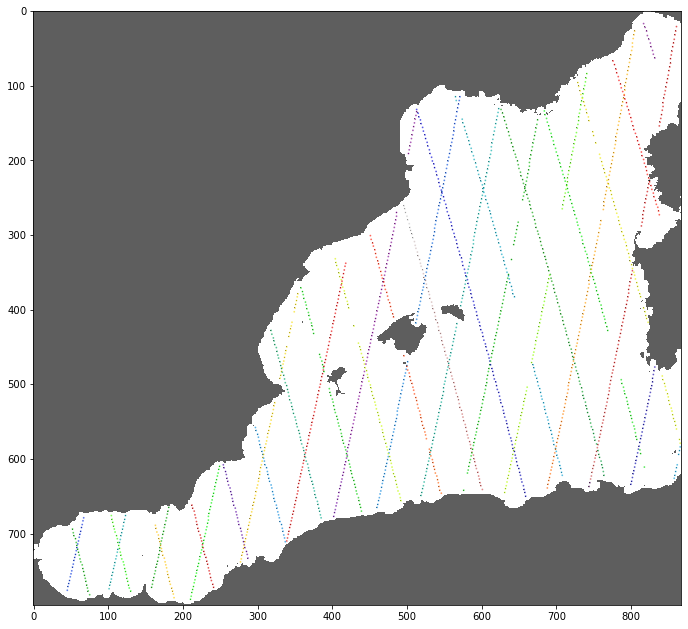

In [6]:
import numpy as nmp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

XFLD = nmp.flipud(Solution.XNPtrack)
(idy,idx) = nmp.where( XFLD > 0 ) ; # that's track points...

XMSK = 1 - nmp.ma.getmask(XFLD).astype(nmp.int8)
pmsk = nmp.ma.masked_where(XMSK<0.1, XMSK*0.7)
del XMSK

(Nj,Ni) = XFLD.shape

fig = plt.figure(num = 1, figsize=(9,9*Nj/Ni), facecolor='w', edgecolor='k')
ax  = plt.axes([0., 0., 1., 1.],     facecolor = 'w')
norm_fld = colors.Normalize(vmin =nmp.amin(XFLD[(idy,idx)]), vmax=nmp.amax(XFLD[(idy,idx)]), clip = False)
cf = ax.scatter(idx, idy, c=XFLD[(idy,idx)], cmap = 'nipy_spectral', norm = norm_fld, alpha=0.5, marker='.', s=3 )
#
norm_lsm = colors.Normalize(vmin = 0., vmax = 1., clip = False)
cm = ax.imshow(pmsk, cmap='Greys', norm=norm_lsm, interpolation='none')


### 2] Plot time series of _interpolated model_ SLA and satellite SLA

Even if probably ugly it gives the pictures of what we are dealing with...

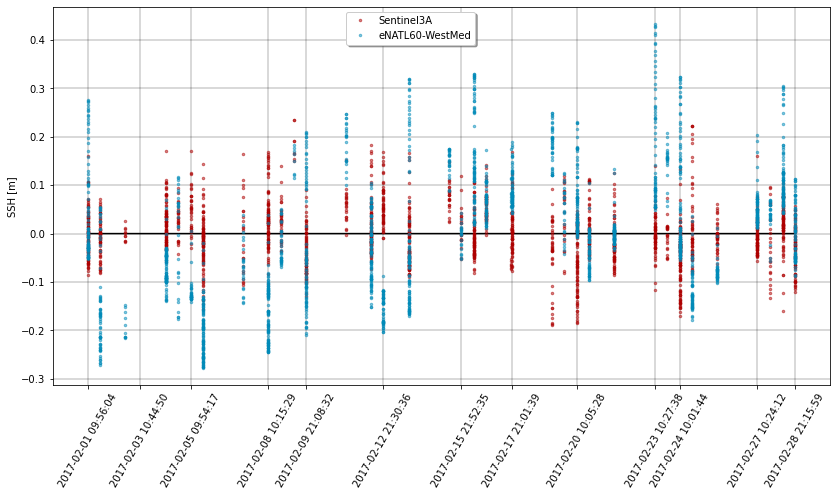

In [7]:
import matplotlib.dates as mdates
                                                                                                        
clr_sat = '#AD0000'
clr_mod = '#008ab8'

VT = mdates.epoch2num(Solution.time) ; # time from UNIX Epoch to Matlplotlib friendly...

fig = plt.figure(num = 1, figsize=(12,7), facecolor='w', edgecolor='k')
ax = plt.axes([0.07, 0.24, 0.9, 0.75])
ax.set_xticks(VT[::200])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation='60')
plt.plot(VT, VT*0.0          , '-', color='k',                   label=None,  zorder=5)
plt.plot(VT, Solution.ssh_sat-nmp.mean(Solution.ssh_sat), '.', color=clr_sat, markersize=5, alpha=0.5, label=name_sat, zorder=10)
plt.plot(VT, Solution.ssh_mod-nmp.mean(Solution.ssh_mod), '.', color=clr_mod, markersize=5, alpha=0.5, label=name_mod, zorder=15)
#ax.set_ylim(-r_max_amp_ssh,r_max_amp_ssh) ;
#ax.set_xlim(VT[0],VT[-1])
plt.ylabel('SSH [m]')
ax.grid(color='k', linestyle='-', linewidth=0.3)
lgnd = plt.legend(bbox_to_anchor=(0.55, 1.), ncol=1, shadow=True, fancybox=True)


## Processing solution for spectral analysis
### 1] Select continuous segments, prepare them for FFT, and apply FFT on each of them

In [8]:
# Extract the Ns continuous data segments:                                                                                                              
ISeg_beg, ISeg_end = gzg.FindUnbrokenSegments( Solution.time, Solution.distance, Solution.ssh_mod, \
                                             rcut_time=1.2, rcut_dist=7.8 )
# => any Δt > 1.2 s between 2 consecutive points is considered as a gap and hence a cut!
# => any Δd > 7.8 km    "               "             "                 "

# Select and retain only the "NbSeg" proper segments:                                                                                                               
NbSeg, Nsl, IDEDSeg = gzg.SegmentSelection(ISeg_beg, ISeg_end, np_valid_seg=70)
# Debug validity check:                                                                                                                                       
#for js in range(NbSeg):                                                                                                                                
#    print(' * Seg # ',js+1,' => it1, it2 =', IDEDSeg[js,:], ' ==> len = ', IDEDSeg[js,1]-IDEDSeg[js,0]+1)                                              
#print(' Nsl = ',Nsl)

# Process data on segment so ready for FFT:                                                                                                 
XPs, XPm, rdist_sample = gzg.Process4FFT( IDEDSeg, Solution.distance, Solution.ssh_mod, Solution.ssh_sat )

# Apply FFT !                                                                                                                               
Kwn, PwSpc_s, PwSpc_m = gzg.ApplyFFT( IDEDSeg, XPs, XPm, rdist_sample )


 *** [SegmentSelection()]: Will use 5 segments with a fixed length of 80 points!
     ==> 5 selected segments out of the 74 available (requested minimum length is 70 points)

 *** [Process4FFT()]: applying linear detrending...
 *** [Process4FFT()]: centering about 0...
 *** [Process4FFT()]: applying "Tukey" tappering...

 *** [ApplyFFT()]: Applying FFT with a dx_sample of  6.7  km



### 2] Plotting the mean spectrum

In [9]:
CLIMPORN_DIR = getenv('HOME')+'/DEV/climporn/python' ; # get it there: https://github.com/brodeau/climporn
sys.path.append(CLIMPORN_DIR)
import climporn as cp

# Building our spectrum as the mean of the NbSeg spectra:
vps_mod = nmp.mean(PwSpc_m[:,:],axis=0)
vps_sat = nmp.mean(PwSpc_s[:,:],axis=0)

# Blabla for the plot:
cinfrm = str(NbSeg)+' segments\n'+str(Nsl)+' points/segment\n'+r'$\Delta$d sat.: '+str(round(rdist_sample,1))+' km'

ii = cp.plot("pow_spectrum_ssh")(Kwn, vps_mod, clab1=name_mod+' ("'+name_ssh_mod+'")', clr1=clr_mod, lw1=5, \
                                 cinfo=cinfrm, logo_on=False, \
                                 L_min=13., L_max=500., P_min_y=-6, P_max_y=1, \
                                 l_show_k4=False, l_show_k5=True, l_show_k11o3=False, l_show_k2=True, \
                                 vk2=Kwn, vps2=vps_sat, clab2=name_sat+' ("'+name_ssh_sat+'")', clr2=clr_sat, lw2=4)


ModuleNotFoundError: No module named 'climporn'